In [1]:
import os
import sys
os.environ["OMP_NUM_THREADS"] = "11"
os.environ["OPENBLAS_NUM_THREADS"] = "8" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "11" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "11" # export NUMEXPR_NUM_THREADS=6
os.environ["NUMBA_CACHE_DIR"]='/tmp/numba_cache'
import numpy as np
import pandas as pd
import scipy as sp
import scipy.sparse
import h5py

import tensorflow as tf
import matplotlib.pyplot as plt
import scanpy as sc

# add parent folder path to load our package
import sys; sys.path.insert(0, '..')

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# Load data

In [2]:
with h5py.File('dogma_cite_asap.h5', 'r') as f:
    print(f.keys())
    ADT_names = np.array(f['ADT_names'], dtype='S32').astype(str)
    gene_names = np.array(f['gene_names'], dtype='S32').astype(str)
    
    # Count matrices of three modalities: X for genes, Y for ADT, and Z for peaks.
    X = sp.sparse.csc_matrix(
        (np.array(f['RNA.data'], dtype=np.float32), 
         np.array(f['RNA.indices'], dtype=np.int32),
         np.array(f['RNA.indptr'], dtype=np.int32)
        ), 
        shape = np.array(f['RNA.shape'], dtype=np.int32)).tocsc().astype(np.float32)
    Y = np.array(f['ADT'], dtype=np.float32)
    cell_types = np.array(f['cell_types'], dtype='S32').astype(str)
    
    # The covariate matrix, the last column is the ids of datasets
    batches = np.array(f['batches'], dtype=np.float32)
    
    # The indices of features that are observed in each dataset.
    id_X_cite = np.array(f['id_X_cite'], dtype=np.int32)
    id_Y_cite = np.array(f['id_Y_cite'], dtype=np.int32)
    id_Y_asap = np.array(f['id_Y_asap'], dtype=np.int32)
    
    # The sample size
    sample_sizes = np.array(f['sample_sizes'], dtype=np.int32)

# Preprocess the data
X = X.toarray()
X[batches[:,-1]!=2,:] = np.log(X[batches[:,-1]!=2,:]/np.sum(X[batches[:,-1]!=2,:], axis=1, keepdims=True)*1e4+1.)
Y = np.log(Y/np.sum(Y, axis=1, keepdims=True)*1e4+1.)
data = np.c_[X, Y]

# Subset the data, only use CITE-seq and ASAP-seq datasets for illustration.
batches = batches[sample_sizes[0]:]
data = data[sample_sizes[0]:]
sample_sizes = sample_sizes[1:]


gene_names = gene_names[id_X_cite] # remove genes not measured in the two datasets
id_Y_cite_val = np.random.choice(id_Y_cite, int(0.1*len(id_Y_cite)), replace=False)
id_Y_cite = np.setdiff1d(id_Y_cite, id_Y_cite_val)
dim_input_arr = np.array([len(gene_names),len(ADT_names)])

data = data[:, np.r_[id_X_cite, id_Y_asap+dim_input_arr[0]]]
data_raw = data.copy()


# The masks indicate missing pattern for the whole datasets.
masks_raw = - np.ones_like(data, dtype=np.float32)
masks_raw[:sample_sizes[0], :] = 0.
masks_raw[sample_sizes[0]:, dim_input_arr[0]:] = 0.

# randomly remove 20% of entries to be missing
# Each row corresponds to a cell, and each column corresponds to a feature.
# If the dataset is large, one can also provide a mask matrix with shape (num_datasets, num_features)
# along with a variable `id_datasets` to reduce memory usages.
# -1 means missing and 0 means observed.
masks = masks_raw.copy()
masks[np.random.rand(*masks.shape) < 0.2] = -1
data = data * (masks != -1)
masks = tf.convert_to_tensor(masks, dtype=tf.float32)

print('Sample sizes: {}. Feature sizes: {}.'.format(sample_sizes, dim_input_arr))

<KeysViewHDF5 ['ADT', 'ADT_names', 'RNA.data', 'RNA.indices', 'RNA.indptr', 'RNA.shape', 'batches', 'cell_ids', 'cell_types', 'gene_names', 'id_X_cite', 'id_X_dogma', 'id_Y_asap', 'id_Y_cite', 'id_Y_dogma', 'id_Z_asap', 'id_Z_dogma', 'peak_names', 'peaks.data', 'peaks.indices', 'peaks.indptr', 'peaks.shape', 'sample_sizes']>
Sample sizes: [8689 8535]. Feature sizes: [2374  227].


# Set up config for model training

In [4]:
import scVAEIT
print(scVAEIT.__version__)

from scVAEIT import VAEIT

path_root = 'result/'

config = {
    # Dimension of input features for [RNA, ADT, peaks]
    'dim_input_arr': dim_input_arr,

    # Blocks for [RNA, ADT]
    'dim_block': np.array([len(gene_names),len(ADT_names)]), # input dimension of blocks
    'dist_block':['NB','NB'], # distributions of blocks
    'dim_block_enc':np.array([128, 64]), # dimension of first layer of the encoder
    'dim_block_dec':np.array([128, 64]), # dimension of first layer of the decoder
    'dim_block_embed':np.array([128, 64]), # mask embedding dimension

    # Internal network structure
    'dimensions':[32], # dimension of latent layers of encoder; the reversed is used for decoder
    'dim_latent':8, # the latent dimension bewteen the encoder and decoder

    # Weights
    'beta_unobs':.9, # weight for masked out observation; weight for observerd values will be 1-beta_unobs.
    'beta_modal':np.array([0.05,0.95]), # weights for 2 modalities, which can be adjusted based on loss in the first few epochs.

    # Masking probability
    "p_feat" : 0.5, # probablity of randomly masking out an entry
}

batches_cate = batches
batches_cont = None

model = VAEIT(config, data, masks, None, batches_cate, batches_cont)

0.2.0
namespace(beta_kl=2.0, beta_reverse=0.2, beta_modal=array([0.05, 0.95]), p_modal=None, uni_block_names=array(['M-0', 'M-1'], dtype='<U23'), block_names=array(['M-0', 'M-1'], dtype='<U23'), dist_block=array(['NB', 'NB'], dtype='<U2'), dim_block=array([2374,  227]), dim_block_enc=array([128,  64], dtype=int32), dim_block_dec=array([128,  64], dtype=int32), skip_conn=False, max_vals=<tf.Tensor: shape=(2601,), dtype=float32, numpy=
array([8.865503, 8.865503, 8.865503, ..., 8.865503, 8.865503, 8.865503],
      dtype=float32)>, dim_input_arr=array([2374,  227]), dim_block_embed=array([128,  64]), dimensions=array([32], dtype=int32), dim_latent=8, beta_unobs=0.9, p_feat=0.5) (17224, 2601) (17224, 2601) (17224, 4)


In [5]:
# Here we only train for 300 epochs for illustration purpose
hist = model.train(
        num_epoch=100, batch_size=256, save_every_epoch=50,
        verbose=True, checkpoint_dir=path_root+'checkpoint/')

Deleting old log directory at result/checkpoint/
Train - Start of epoch 1


2023-11-13 20:58:16.170735: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


68/68 [==============================] - 15s 225ms/step - Reconstructed Loss: 73.5120
Epoch 1, Time elapsed: 0.26 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl
train :   77.99,    4.01,    9.48,   27.65,   32.55,    4.31
Train - Start of epoch 2
68/68 [==============================] - 13s 197ms/step - Reconstructed Loss: 54.9357
Epoch 2, Time elapsed: 0.48 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl
train :   53.47,    3.65,    5.22,   25.06,   18.64,    0.90
Train - Start of epoch 3
68/68 [==============================] - 14s 213ms/step - Reconstructed Loss: 52.0375
Epoch 3, Time elapsed: 0.72 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,      kl
train :   50.73,    3.59,    4.84,   24.60,   17.12,    0.58
Train - Start of epoch 4
68/68 [==============================] - 15s 224ms/step - Reconstructed Loss: 50.4698
Epoch 4, Time elapsed: 0.97 minutes
          total, obs_M-0, obs_M-1, unobs_M-0, unobs_M-1,   

We can visualize the training loss. It flucuates since we argument the data with random masking, which also provides regularization against overfitting.
One may continue training until the loss gets stablized.

Text(0, 0.5, 'Trianing loss')

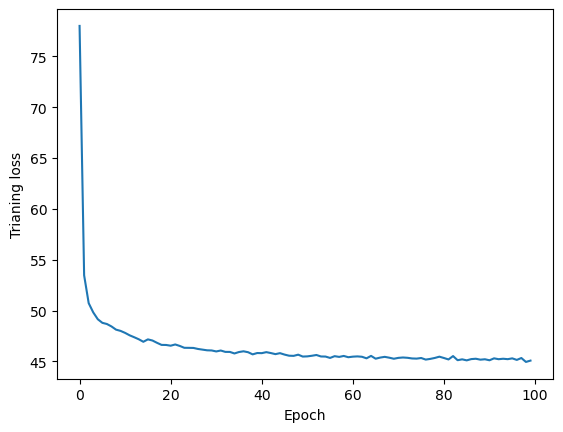

In [6]:
plt.plot(hist['train']['total'])
plt.xlabel('Epoch')
plt.ylabel('Trianing loss')

We can load the trained model:

```python
# load the model and ensure it is loaded successfully
checkpoint = tf.train.Checkpoint(net=model.vae)
n_ckpt = 2
status = checkpoint.restore(path_root+'checkpoint/ckpt-{}'.format(n_ckpt))
model.vae(tf.zeros((1,np.sum(model.vae.config.dim_input_arr))),
          tf.zeros((1,np.sum(model.vae.config.dim_input_arr))),
          tf.zeros((1,np.sum(model.batches.shape[1]))), L=1, training=False)
print(status)
```

# Inspect imputation results

In [7]:
denoised_data = model.get_denoised_data()

Text(0, 0.5, 'Imputed')

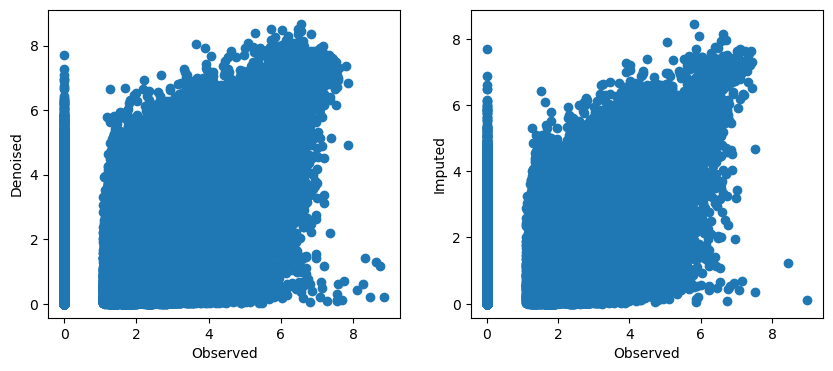

In [9]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(
    data_raw[masks==0],
    denoised_data[masks==0]
    )
axes[0].set_xlabel('Observed')
axes[0].set_ylabel('Denoised')

axes[1].scatter(
    data_raw[(masks_raw==0)&(masks==-1)],
    denoised_data[(masks_raw==0)&(masks==-1)]
    )
axes[1].set_xlabel('Observed')
axes[1].set_ylabel('Imputed')